In [1]:
import torch
import torch.nn as nn

In [2]:
# gpt-2 configurations
GPT_CONFIG_124= {
    'vocab_size' :50257,
    'context_length': 1024,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

In [3]:
#GELU Activation function
class GELU(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self, x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.0447*torch.pow(x,3))))

In [4]:
#Feed Forward Neural network
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']), #incresing dimesion
                                    GELU(),
                                    nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']))  #coming back to original dimension
    def forward(self,x):
        return self.layers(x)

In [5]:
# Layer Normalization
class LayerNorm(nn.Module):
    def __init__(self, emd_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emd_dim))
        self.shift = nn.Parameter(torch.zeros(emd_dim))
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim =True)
        var = x.var(dim =-1, keepdim = True, unbiased= False)
        norm_x = (x-mean)/(torch.sqrt(var+self.eps))
        return self.scale*norm_x + self.shift

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias = False):
        super().__init__()
        assert(d_out % num_heads==0),\
            "d_out must be divisible by nums head"
        
        self.d_out = d_out
        self.num_head = num_heads
        self.head_dim = d_out//num_heads
        # self.d_in = d_in
        self.w_query = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in,d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,x):
        b,num_token,d_in = x.shape

        keys = self.w_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.w_query(x)
        values = self.w_value(x)

        keys = keys.view(b,num_token,self.num_head,self.head_dim)
        queries = queries.view(b,num_token,self.num_head,self.head_dim)
        values = values.view(b,num_token,self.num_head,self.head_dim)

        #grouping by num_heads
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        # calculating attention score
        attn_score = queries @ keys.transpose(2,3)

        # calculating attention weigths,masking, scaling and dropout
        mask_bool = self.mask.bool()[:num_token,:num_token]
        attn_score= attn_score.masked_fill_(mask_bool, - torch.inf)
        attn_weight = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
        attn_weight = self.dropout(attn_weight)
        
        #calculating the context vector
        context_vector = attn_weight @ values #ntokn x ntoken * ntoken x head_dim
        # trasposing to get all the context vextor togeth
        context_vector = context_vector.transpose(1,2)

        # combining heads 
        context_vector = context_vector.contiguous().view(b,num_token,self.d_out)
        context_vector = self.out_proj(context_vector) # optional projection
        return context_vector

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.attn = MultiHeadAttention(d_in=cfg['emb_dim'], d_out= cfg['emb_dim'],
                                       context_length=cfg['context_length'],
                                       num_heads=cfg['n_heads'], dropout= cfg['drop_rate'],
                                       qkv_bias= cfg['qkv_bias'])
        self.ff = FeedForward(cfg=cfg)
        self.norm1 = LayerNorm(emd_dim=cfg['emb_dim'])
        self.norm2 = LayerNorm(emd_dim=cfg['emb_dim'])

        self.drop_shortcut  = nn.Dropout(cfg['drop_rate'])
    
    def forward(self,x):
        shortcut = x
        x= self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)

        x = x+ shortcut

        shortcut =x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


In [8]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm  = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'], bias=False)
    def forward(self,in_idx):
        batch_size, seq_len = in_idx.shape
        token_embded = self.tok_emb(in_idx)
        pos_embded = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = token_embded+pos_embded
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [9]:
# gpt-2 configurations
GPT_CONFIG_124M= {
    'vocab_size' :50257,
    'context_length': 256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

In [10]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [11]:
def generate_text_simple(model, idx, max_words, context_size):

    for _  in range(max_words):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        probas = torch.softmax(logits,dim=-1)
        idx_next = torch.argmax(probas,dim=-1,keepdim=True)
        idx = torch.cat((idx,idx_next), dim=1)
    return idx

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [13]:
def text_to_token(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor
def token_to_text(ids, tokenizer):
    flat = ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [14]:
batch = []
out_batch =[]
txt1 = "Every effort moves"
txt2 = "I really like"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100],
        [  40, 1107,  588]])


In [15]:
output = torch.tensor([[3626,6100,345],
                       [1107,588,11311]])
output

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [16]:
with torch.no_grad():
    logits = model(batch)
probas = torch.softmax(logits,dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [17]:
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print(token_ids)

tensor([[[31093],
         [16031],
         [44376]],

        [[49906],
         [ 3684],
         [38185]]])


In [18]:
print("Targrt batch1:", token_to_text(output[0],tokenizer))
print("prediction batch1:", token_to_text(token_ids[0].flatten(),tokenizer))

Targrt batch1:  effort moves you
prediction batch1:  moons saves inaction


### Cross Entropy Loss

In [19]:
text_idx = 0
target_proba_1 = probas[text_idx, [0,1,2], output[text_idx]]
print("Text 1:", target_proba_1)

text_idx = 1
target_proba_2 = probas[text_idx, [0,1,2], output[text_idx]]
print("Text 2: ", target_proba_2)

Text 1: tensor([3.1416e-05, 2.0867e-05, 1.1188e-05])
Text 2:  tensor([1.3012e-05, 6.0395e-05, 4.8063e-06])


In [20]:
log_proba = torch.log(torch.cat((target_proba_1,target_proba_2)))
print(log_proba)
avg_log_proba = torch.mean(log_proba)
print(avg_log_proba)
neg_log_proba = avg_log_proba*-1
print(neg_log_proba)

tensor([-10.3682, -10.7774, -11.4007, -11.2496,  -9.7146, -12.2456])
tensor(-10.9593)
tensor(10.9593)


In [21]:
# doing these all with onliner 
target_flat = output.flatten()
logits_flat = logits.flatten(0,1)
loss = torch.nn.functional.cross_entropy(logits_flat,target_flat)
print(loss)

tensor(10.9593)


### Perplexity

In [22]:
p_loss = torch.exp(loss)

In [23]:
p_loss

tensor(57488.4375)

### Calculating the loss for the entire dataset

In [24]:
import os
with open("the-verdict.txt", 'r', encoding= 'utf-8') as f:
    raw_data = f.read()
# print(raw_data)

In [25]:
raw_data[:25]

'I HAD always thought Jack'

In [26]:
print(len(raw_data))

20479


In [27]:
print("No of tokens:" , len(tokenizer.encode(raw_data)))

No of tokens: 5145


In [28]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self,text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids= []

        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids)-max_length,stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunck = token_ids[i+1:i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunck))
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [29]:
def create_dataloader(text, batch_size=4, max_length = 256, stride = 256, shuffle = True, drop_last = True, num_workers = 0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text=text, tokenizer=tokenizer,max_length=max_length,stride=stride)
    #Creating dataloader
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)
    return dataloader

In [30]:
# gpt-2 configurations
GPT_CONFIG_124M= {
    'vocab_size' :50257,
    'context_length': 256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

In [31]:
train_ratio = 0.90
split_idx = int(train_ratio*len(raw_data))
train_data = raw_data[:split_idx]
test_data = raw_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
    text=train_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride= GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle= True,
    num_workers=0
)

val_loader = create_dataloader(
    text=test_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride= GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle= True,
    num_workers=0
)

In [32]:
for x,y in train_loader:
    print(x.shape, y.shape)
print("Output shape;")
for x,y in  val_loader:
    print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Output shape;
torch.Size([2, 256]) torch.Size([2, 256])


In [33]:
#counting the train and validation tokens
train_token = 0
val_token = 0
for input_batch, out_batch in train_loader:
    train_token += input_batch.numel()
for x, y in val_loader:
    val_token += x.numel()
print("Input tokens count:" , train_token)
print("NO of validation token :", val_token)
print("total tokens :", train_token+val_token)

Input tokens count: 4608
NO of validation token : 512
total tokens : 5120


In [34]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm  = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'], bias=False)
    def forward(self,in_idx):
        batch_size, seq_len = in_idx.shape
        token_embded = self.tok_emb(in_idx)
        pos_embded = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        x = token_embded+pos_embded
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)


In [36]:
def calc_loss_batch(input_batch,target_batch,model, device):
    input_batch , target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_score( data_loader, model, device, num_batches = None):
    total_loss = 0
    if len(data_loader) ==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)

    for i ,(input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            total_loss += loss.item()
        else:
            break

    return total_loss/num_batches
            
    

In [ ]:
#calculating the loss for both the train_set and the validation_set
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# with torch.no_grad():
#     train_loss = calc_loss_score(train_loader, model=model, device=device)
#     val_loss = calc_loss_score(val_loader, model=model, device=device)

In [ ]:
# print("train_loss: ", train_loss)
# print("Validation loss", val_loss)

train_loss:  10.995637469821506
Validation loss 10.996355056762695


In [39]:
#calculating the loss for harry potter book

with open('01HarryPotterandtheSorcerers.txt', 'r', encoding='utf-8') as f:
    harry_potter  = f.read()

In [40]:
train_ratio = 0.90
split_idx = int(train_ratio*len(harry_potter))
train_data = harry_potter[:split_idx]
test_data = harry_potter[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
    text=train_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride= GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle= True,
    num_workers=0
)

val_loader = create_dataloader(
    text=test_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride= GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle= True,
    num_workers=0
)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# with torch.no_grad():
#     train_loss = calc_loss_score(train_loader, model=model, device=device)
#     val_loss = calc_loss_score(val_loader, model=model, device=device)

In [ ]:
# print("train_loss: ", train_loss)
# print("Validation loss", val_loss)

train_loss:  10.966798134900014
Validation loss 10.9551074107488


In [43]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

## TRAINING MODEL

In [50]:
train_ratio = 0.90
split_idx = int(train_ratio*len(raw_data))
train_data = raw_data[:split_idx]
test_data = raw_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
    text=train_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride= GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle= True,
    num_workers=0
)

val_loader = create_dataloader(
    text=test_data,
    batch_size=2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride= GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle= True,
    num_workers=0
)

In [51]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_score(data_loader=train_loader, model= model,device=device, num_batches=eval_iter)
        val_loss = calc_loss_score(data_loader=val_loader, model= model,device=device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [52]:
def generate_and_print_sample(mode, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token(start_context, tokenizer=tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_words=50, context_size=context_size)
    decoded_text = token_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n',' '))
    model.train()

In [53]:
def train_model_simple(model,train_loader, val_loader, optimizer, device, num_epochs, eval_frq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [] ,[]
    tokens_seen , global_step = 0,-1
    #main training loop
    for epoch in range(num_epochs):
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()
            loss= calc_loss_batch(input_batch=input_batch, target_batch=target_batch,model=model,device=device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_frq ==0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen    
        

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_frq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 8.050, Val loss 8.333
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.758, Val loss 7.046
Ep 2 (Step 000015): Train loss 6.142, Val loss 6.630
Every effort moves you, and, and, and, and, and, and, and.                                   
Ep 3 (Step 000020): Train loss 13.926, Val loss 14.195
Ep 3 (Step 000025): Train loss 5.513, Val loss 6.420
Every effort moves you, and to the"                                             
Ep 4 (Step 000030): Train loss 5.165, Val loss 6.381
Ep 4 (Step 000035): Train loss 4.753, Val loss 6.316
Every effort moves you.                           "I"I"I"I it's"I"I"I"I"I"I
Ep 5 (Step 000040): Train loss 4.627, Val loss 6.394
Every effort moves you, I had been.                       "II me, and he had the donkey.           
Ep 6 (Step 000045): Train loss 4.026, Val loss 6.260
Ep 6 (Step 000050): Train loss 3.541, Val lo

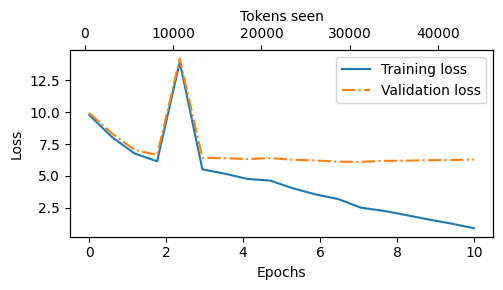

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)